In [ ]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "Figs/"
  
  ensure_dir(save_dir)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import jax.numpy as jnp
from jax import random, jit
import os
from jax.config import config
config.update("jax_enable_x64", True) # Enable float64 for JAX

# High Dimensional Linear Regression Example

In [ ]:
def perceptron_expt(pvals, w_target, N, lamb, sigma, num_repeats, mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian'):
  errs = np.zeros((len(pvals), num_repeats))
  key = random.PRNGKey(1)
  for i,p in enumerate(pvals):
    for j in range(num_repeats):
      key, teach, train, test, noise = random.split(key, 5)
      if dist == 'gaussian': X_tr = random.multivariate_normal(train, mean_tr, cov_tr, shape = (p,))
      if dist == 'gaussian': X_te = random.multivariate_normal(test, mean_test, cov_test, shape = (5000,))

      if dist == 'rect': X_tr = random.normal(train, shape = (p,N+dN))@cov_tr
      if dist == 'rect': X_te = random.normal(train, shape = (5000,N+dN))@cov_test

      y = X_tr @ w_target + sigma * random.normal(noise, (p,)) 
      y_true = X_te @ w_target
      X_tr = X_tr[:,0:N]
      X_te = X_te[:,0:N]
      if lamb == 0:
        if p < N:
          yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T) @ y
        else:
          yhat = X_te @ jnp.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y
      else:
        yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T + lamb*jnp.eye(p)) @ y

      errs[i,j] = np.mean((yhat - y_true)**2)
  return errs

In [ ]:
def kappa_fn(kappa, *args):
    (p, lamb, C, K) = args
    D = C.shape[0]
    mat = lambda p: np.linalg.inv(p*C@K + kappa*np.identity(D))
    return kappa - lamb - kappa * np.trace(C@K @ mat(p))

def kappa_fn_derivative(kappa, *args):
    (p, lamb, C, K) = args
    D = C.shape[0]
    mat = lambda p: np.linalg.inv(p*C@K + kappa*np.identity(D))
    return 1 - np.trace(C@K@mat(p)) + kappa*np.trace(mat(p)@C@K@mat(p))

def solve_kappa(pvals, lamb, C, K):
    sols = np.zeros(len(pvals))
    eig,_ = np.linalg.eigh(C)
    for i, p in enumerate(pvals):
        args = (p, lamb, C, K)
        sols[i] = sp.optimize.root_scalar(kappa_fn, x0 = p*max(eig), args = args,
                                          fprime = kappa_fn_derivative, method = 'newton').root
    return sols

def gamma_fn(p, kappa, C, K):
    D = C.shape[0]
    mat = lambda p: p*C@K + kappa*np.identity(D)
    return p*np.trace(C@K @C@K @np.linalg.inv(mat(p))@np.linalg.inv(mat(p)))

def gamma_prime_fn(p, kappa, C, K, Cprime):
    D = C.shape[0]
    mat = lambda p: p*C@K + kappa*np.identity(D)
    return p*np.trace(Cprime@K @ C@K @np.linalg.inv(mat(p))@np.linalg.inv(mat(p)))

def theory_gen(ptheory, w_target, sigma, lamb, cov_tr, cov_test, K, diag):

  if diag is False:
    assert dN == 0, 'When covariance is not diagonal out-of-RKHS theory is not implemented!'

  D = cov_tr.shape[0]
  # Define gamma and f as a function of p
  gamma = lambda p, kappa: gamma_fn(p, kappa, cov_tr, K)
  gamma_prime = lambda p, kappa: gamma_prime_fn(p, kappa, cov_tr, K, cov_test)
  mat = lambda p, kappa: np.linalg.inv(p*cov_tr@K + kappa*np.identity(D))

  ## Solve implicit equation
  kappa_vals = solve_kappa(ptheory, lamb, cov_tr, K)
  gamma_vals = np.array([gamma(ptheory[i], kappa_vals[i]) for i in range(len(ptheory))])
  gamma_prime_vals = np.array([gamma_prime(ptheory[i], kappa_vals[i]) for i in range(len(ptheory))])

  ## Create a matrix for mat:
  mat_vals = np.array([mat(ptheory[i], kappa_vals[i]) for i in range(len(ptheory))])

  eg0_vals = np.array([w_target@mat_vals[i]@cov_tr@mat_vals[i]@w_target for i in range(len(ptheory))])
  eg_corr_vals = np.array([w_target@mat_vals[i]@(cov_test - (1-gamma_prime_vals[i])/(1-gamma_vals[i])*cov_tr)@mat_vals[i]@w_target for i in range(len(ptheory))])

  Eg_0 = gamma_vals/(1-gamma_vals)*sigma**2 + (kappa_vals)**2/(1-gamma_vals) * eg0_vals

  Eg_corr = (gamma_prime_vals - gamma_vals)/(1-gamma_vals)*sigma**2 + (kappa_vals)**2 * eg_corr_vals
    
  gen_err = Eg_0 + Eg_corr

  return gen_err

def tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag = True):
  mean_tr = np.zeros(N + dN)
  mean_test = np.zeros(N + dN)
  if diag:
    cov_tr = np.ones(N + dN) * sigma_tr # squared std
    cov_test = np.ones(N + dN) * sigma_test  # squared std
    if M_tr > 0: cov_tr[-M_tr:] = 1e-18
    if M_test > 0: cov_test[-M_test:] = 1e-18
    cov_tr = np.diag(cov_tr)
    cov_test = np.diag(cov_test)
  if not diag:
    ## make sure positive definite
    M = np.random.normal(size = (N + dN,N + dN))
    Eig = np.ones(N+dN)
    if M_tr > 0: Eig[-M_tr:] = 1e-10
    cov_tr = M@np.diag(Eig)@M.T/(N + dN) * sigma_tr # squared std
    cov_test = np.identity(N + dN)

  return mean_tr, mean_test, cov_tr, cov_test

def kernel_target(N, dN, M_beta):
  k_null = np.ones(N + dN)
  if dN > 0: k_null[-dN:] = 1e-18

  ## Make sure target power always adds up to 1
  w_target = np.random.normal(0,1, (N + dN,))/np.sqrt(N+dN-M_beta)  # Fix the target weights
  if M_beta > 0: w_target[-M_beta:] = 0

  return np.diag(k_null), w_target

# Figure 1: Fixed \#Features, \#Test, \#Target, Vary Training

In [ ]:
key = random.PRNGKey(1)

# Experiment parameters
N = 120 # Number of features expressed in the kernel
dN = 0 # Number of features not expressed in the kernel
noise_var = np.sqrt(0.0)
num_repeats = 30
pexpt = jnp.logspace(1, np.log10(5*N),num = 10).astype('int')
ptheory = jnp.logspace(1, np.log10(5*N), num = 100)

# Set the distribution

M_beta = 60 ## Set some target weights to 0
M_test = 0
sigma_test = 1

K, w_target = kernel_target(N, dN, M_beta)
w_target = np.random.normal(0,1, (N + dN,))  # Fix the target weights
if M_beta > 0: w_target[-M_beta:] = 0
w_target[40:] = w_target[40:]/10
w_target = w_target/np.linalg.norm(w_target)
K = K/N

M_tr_list = [0, 20, 40, 60, 80, 90]

err_vary_M = []
std_vary_M = []
theory_vary_M = []
for M_tr in M_tr_list:
  ## Vary M_tr
  diag_dist = True
  sigma_tr = 1
  mean_tr, mean_test, cov_tr, cov_test = tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag=diag_dist)

  lamb = 1e-3

  experiment = lambda lamb: perceptron_expt(pexpt, w_target, N, lamb*N, noise_var, num_repeats, 
                                            mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian')


  expt = experiment(lamb)
  err_vary_M += [expt.mean(axis=1)]
  std_vary_M += [expt.std(axis=1)]
  theory_errs = theory_gen(ptheory, w_target, noise_var, lamb, cov_tr, cov_test, K, diag_dist)
  theory_vary_M += [theory_errs]

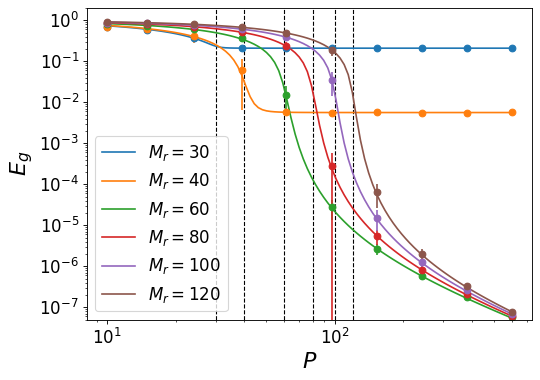

In [ ]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(7, 5), dpi=80)

plt.ylim(5e-8, 2e-0)

fig.subplots_adjust(wspace=-0)
### Plotting
for i, M_tr in enumerate(M_tr_list[::-1]):

  plt.errorbar(pexpt, err_vary_M[::-1][i], std_vary_M[::-1][i], fmt='o', color = 'C%d'%i)
  plt.loglog(ptheory, theory_vary_M[::-1][i], color = 'C%d'%i, label = '$M_{r} = %d$'%(N+dN-M_tr))

  plt.vlines(N+dN-M_tr,5e-9,2e-0,linestyle = 'dashed', color='k', linewidth=1)

plt.legend()
plt.xlabel(r'$P$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.tight_layout()
plt.savefig('linear_regression_vary_M_tr.pdf')
plt.show()

# Figure 4

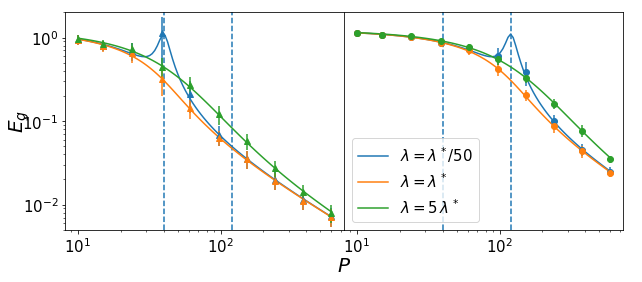

In [ ]:
key = random.PRNGKey(1)

# Experiment parameters
N = 120 # Number of features expressed in the kernel
dN = 0 # Number of features not expressed in the kernel
noise_var = np.sqrt(0.1)
num_repeats = 30
pexpt = jnp.logspace(1, np.log10(5*N),num = 10).astype('int')
ptheory = jnp.logspace(1, np.log10(5*N), num = 100)

# Set the distribution

M_beta = 80 ## Set some target weights to 0
M_test = 0
sigma_test = 1

K, w_target = kernel_target(N, dN, M_beta)
K = K/N

## Vary training
diag_dist = True
M_tr = 0
sigma_tr = 1
mean_tr, mean_test, cov_tr, cov_test = tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag=diag_dist)

opt_reg = noise_var**2*(N+dN-M_tr)/N
lamb_vals = np.array([opt_reg/50, opt_reg, opt_reg*5])

experiment = lambda lamb: perceptron_expt(pexpt, w_target, N, lamb*N, noise_var, num_repeats, 
                                          mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian')


err_full_dist = []
std_full_dist = []
theory_full_dist = []
for i, lamb in enumerate(lamb_vals):
  expt = experiment(lamb)
  err_full_dist += [expt.mean(axis=1)]
  std_full_dist += [expt.std(axis=1)]
  theory_errs = theory_gen(ptheory, w_target, noise_var, lamb, cov_tr, cov_test, K, diag_dist)
  theory_full_dist += [theory_errs]

## Vary training
diag_dist = True
M_tr = M_beta
sigma_tr = 1
mean_tr, mean_test, cov_tr, cov_test = tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag=diag_dist)

opt_reg = noise_var**2*(N+dN-M_tr)/N
lamb_vals = np.array([opt_reg/50, opt_reg, opt_reg*5])

experiment = lambda lamb: perceptron_expt(pexpt, w_target, N, lamb*N, noise_var, num_repeats, 
                                          mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian')


err_target_dist = []
std_target_dist = []
theory_target_dist = []
for i, lamb in enumerate(lamb_vals):
  expt = experiment(lamb)
  err_target_dist += [expt.mean(axis=1)]
  std_target_dist += [expt.std(axis=1)]
  theory_errs = theory_gen(ptheory, w_target, noise_var, lamb, cov_tr, cov_test, K, diag_dist)
  theory_target_dist += [theory_errs]


fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 4))


for i in range(len(axs)):
    axs[i].set_ylim(5e-3, 2e-0)
axs[1].axes.get_yaxis().set_visible(False)

fig.subplots_adjust(wspace=-0)
### Plotting
for i, lamb in enumerate(lamb_vals):
  if i == 0: label = r'$\lambda = \lambda^*/50$'
  if i == 1: label = r'$\lambda = \lambda^*$'
  if i == 2: label = r'$\lambda = 5\,\lambda^*$'

  axs[1].errorbar(pexpt, err_full_dist[i], std_full_dist[i], fmt='o', color = 'C%d'%i)
  axs[1].loglog(ptheory, theory_full_dist[i], color = 'C%d'%i,label = label)
  axs[0].errorbar(pexpt, err_target_dist[i], std_target_dist[i], fmt='^', color = 'C%d'%i)
  axs[0].loglog(ptheory, theory_target_dist[i], color = 'C%d'%i)

axs[0].vlines(N,5e-3,2e-0,linestyle = 'dashed')
axs[0].vlines(N-M_tr,5e-3,2e-0,linestyle = 'dashed')
axs[1].vlines(N,5e-3,2e-0,linestyle = 'dashed')
axs[1].vlines(N-M_tr,5e-3,2e-0,linestyle = 'dashed')

plt.legend()
ax = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
ax.yaxis.set_label_coords(-.06, 0.5)
plt.xlabel(r'$P$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.savefig('linear_regression_curve.pdf')
plt.show()

# SI Figure

In [ ]:
key = random.PRNGKey(1)

# Experiment parameters
N = 120 # Number of features expressed in the kernel
dN = 40 # Number of features not expressed in the kernel
noise_var = np.sqrt(0)
num_repeats = 10
pexpt = jnp.logspace(1, np.log10(100*N),num = 10).astype('int')
ptheory = jnp.logspace(1, np.log10(100*N), num = 100)
lamb_vals = np.array([1e-4])

diag_dist = True
sigma_test = 1
sigma_tr = 1

M_beta = 0 ## Set some target weights to 0
K, w_target = kernel_target(N, dN, M_beta)
K = K/N

In [ ]:
#### Show irreducible error can be avoided by not testing. Double-descent still is visible.
# Set the distribution
M_tr = 20
M_test = 0

mean_tr, mean_test, cov_tr, cov_test = tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag=diag_dist)

experiment = lambda lamb: perceptron_expt(pexpt, w_target, N, lamb*N, noise_var, num_repeats, 
                                          mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian')


err_irreducible = []
std_irreducible = []
theory_irreducible = []
for i, lamb in enumerate(lamb_vals):
  expt = experiment(lamb)
  err_irreducible += [expt.mean(axis=1)]
  std_irreducible += [expt.std(axis=1)]
  theory_irreducible = [theory_gen(ptheory, w_target, noise_var, lamb, cov_tr, cov_test, K, diag_dist)]

# Set the distribution
M_tr = 20
M_test = dN

mean_tr, mean_test, cov_tr, cov_test = tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag=diag_dist)

experiment = lambda lamb: perceptron_expt(pexpt, w_target, N, lamb*N, noise_var, num_repeats, 
                                          mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian')


err_no_irreducible = []
std_no_irreducible = []
theory_no_irreducible = []
for i, lamb in enumerate(lamb_vals):
  expt = experiment(lamb)
  err_no_irreducible += [expt.mean(axis=1)]
  std_no_irreducible += [expt.std(axis=1)]
  theory_no_irreducible = [theory_gen(ptheory, w_target, noise_var, lamb, cov_tr, cov_test, K, diag_dist)]

In [ ]:
#### Show double-descent can be avoided by not training. Still there is irreducible error.
# Set the distribution
M_tr = 20
M_test = 0

mean_tr, mean_test, cov_tr, cov_test = tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag=diag_dist)


experiment = lambda lamb: perceptron_expt(pexpt, w_target, N, lamb*N, noise_var, num_repeats, 
                                          mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian')


err_double_descent = []
std_double_descent = []
theory_double_descent = []
for i, lamb in enumerate(lamb_vals):
  expt = experiment(lamb)
  err_double_descent += [expt.mean(axis=1)]
  std_double_descent += [expt.std(axis=1)]
  theory_double_descent = [theory_gen(ptheory, w_target, noise_var, lamb, cov_tr, cov_test, K, diag_dist)]

# Set the distribution
M_tr = dN
M_test = 0

mean_tr, mean_test, cov_tr, cov_test = tr_test_distributions(N, dN, M_tr, M_test, sigma_tr, sigma_test, diag=diag_dist)


experiment = lambda lamb: perceptron_expt(pexpt, w_target, N, lamb*N, noise_var, num_repeats, 
                                          mean_tr, cov_tr, mean_test, cov_test, dist = 'gaussian')


err_no_double_descent = []
std_no_double_descent = []
theory_no_double_descent = []
for i, lamb in enumerate(lamb_vals):
  expt = experiment(lamb)
  err_no_double_descent += [expt.mean(axis=1)]
  std_no_double_descent += [expt.std(axis=1)]
  theory_no_double_descent = [theory_gen(ptheory, w_target, noise_var, lamb, cov_tr, cov_test, K, diag_dist)]

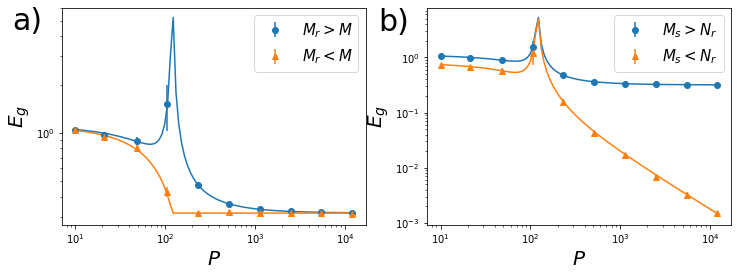

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))

### Plotting
for i, lamb in enumerate(lamb_vals):
  if i == 0: label = r'$\lambda = \lambda^*/50$'
  if i == 1: label = r'$\lambda = \lambda^*$'
  if i == 2: label = r'$\lambda = 5\,\lambda^*$'

  axs[1].errorbar(pexpt, err_full_dist[i], std_full_dist[i], fmt='o', color = 'C%d'%i, label="$M_s > N_r$")
  axs[1].loglog(ptheory, theory_full_dist[i], color = 'C%d'%i)
  axs[1].errorbar(pexpt, err_target_dist[i], std_target_dist[i], fmt='^', color = 'C%d'%(i+1), label="$M_s < N_r$")
  axs[1].loglog(ptheory, theory_target_dist[i], color = 'C%d'%(i+1))
  axs[1].legend(fontsize=15)
  axs[1].set_xlabel(r'$P$', fontsize = 20)
  axs[1].set_ylabel(r'$E_g$', fontsize = 20)
  axs[1].text(2,3,'b)', fontsize=30)

  axs[0].errorbar(pexpt, err_double_descent[i], std_double_descent[i], fmt='o', color = 'C%d'%i, label="$M_r > M$")
  axs[0].loglog(ptheory, theory_double_descent[i], color = 'C%d'%i)
  axs[0].errorbar(pexpt, err_no_double_descent[i], std_no_double_descent[i], fmt='^', color = 'C%d'%(i+1), label="$M_r < M$")
  axs[0].loglog(ptheory, theory_no_double_descent[i], color = 'C%d'%(i+1))
  axs[0].legend(fontsize=15)
  axs[0].set_xlabel(r'$P$', fontsize = 20)
  axs[0].set_ylabel(r'$E_g$', fontsize = 20)
  axs[0].text(2,4.4,'a)', fontsize=30)

plt.savefig('SI_linear_regression_curve.pdf')
plt.show()

# Average Estimator

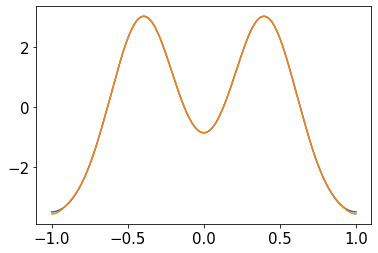

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random, jit
from jax.config import config
# Enable float64 for JAX
config.update("jax_enable_x64", True)

def kernel(x, xp):
    K = jnp.zeros((x.shape[0], xp.shape[0]))
    diff = jnp.outer(jnp.ones(x.shape[0]), xp) - jnp.outer(x, jnp.ones(xp.shape[0]))
    for k in range(1, num_k+1):
        K += jnp.cos(np.pi * k * diff)
    return K

kernel = jit(kernel)

num_k = 10
P = 1000
x_fine = np.linspace(-1, 1, P)

cos_features = lambda x, L = 1: np.array([jnp.cos(np.pi *k * x / L) for k in range(1,num_k+1)])*np.sqrt(L)
sin_features = lambda x, L = 1: np.array([jnp.sin(np.pi *k * x / L) for k in range(1,num_k+1)])*np.sqrt(L)
concat_features = np.concatenate((cos_features(x_fine),sin_features(x_fine)),axis=0)

a = 2
phi = np.pi/2.5
f = lambda x: (np.exp(a * np.cos(np.pi*x-phi)) + np.exp(a* np.cos(np.pi*x+phi)))# * (x < np.pi/2) * (x > -np.pi/2)
target = f(x_fine)
mean_target = np.mean(target)

f_centered = lambda x: f(x) - mean_target
target = f_centered(x_fine)
plt.plot(x_fine, target)
target = 2 / P * cos_features(x_fine).T @ cos_features(x_fine) @ target

plt.plot(x_fine, target)

In [ ]:
def average_estimator(p_vals, x_fine, x_test, tr_range_list, dist, lamb, rep_num, sigma):
  mean_fine = []
  std_fine = []
  mean_test = []
  std_test = []
  for tr_range in tr_range_list:
    yhat = np.zeros ((len(pvals), rep_num, len(x_fine)))
    yhat_test = np.zeros ((len(pvals), rep_num, len(x_fine)))
    ytheory = np.zeros ((len(pvals), len(x_fine)))

    key = random.PRNGKey(1)
    for i, p in enumerate(pvals):
      ytheory[i] = p/(2*num_k)*target
      for j in range(rep_num):
        key, key_tr = random.split(key, 2)
        if dist == 'rectangular': xi = random.uniform(key_tr, minval = -1, maxval = 1, shape = (p,))*tr_range#*np.sqrt(3)
        if dist == 'gaussian': xi = random.normal(key_tr, shape = (p,))*tr_range
        yi = f_centered(xi)
        yi += sigma * np.random.standard_normal(p)
        K = kernel(xi, xi)
        alpha = jnp.linalg.solve(K + lamb*jnp.eye(p), yi)

        K_fine = kernel(x_fine, xi)
        yhat[i,j] = K_fine @ alpha

        K_test = kernel(x_test, xi)
        yhat_test[i,j] = K_test @ alpha

    mean_fine += [yhat.mean(axis = 1)]
    std_fine  += [yhat.std(axis = 1)]

    mean_test += [yhat_test.mean(axis = 1)]
    std_test  += [yhat_test.std(axis = 1)]
  
  return mean_fine, std_fine, mean_test, std_test


In [ ]:
lamb = 1e-8
rep_num = 100
sigma = 0. / len(x_fine)

pvals = [10, 20, 40, 80, 2000]
x_test = x_fine*2.2
tr_range_list = [0.3, 0.5, 0.6]

mean_fine_gauss, std_fine_gauss, mean_test_gauss, std_test_gauss = average_estimator(pvals, x_fine, x_test, tr_range_list, 'gaussian', lamb, rep_num, sigma)
mean_fine_rect, std_fine_rect, mean_test_rect, std_test_rect = average_estimator(pvals, x_fine, x_test, tr_range_list, 'rectangular', lamb, rep_num, sigma)

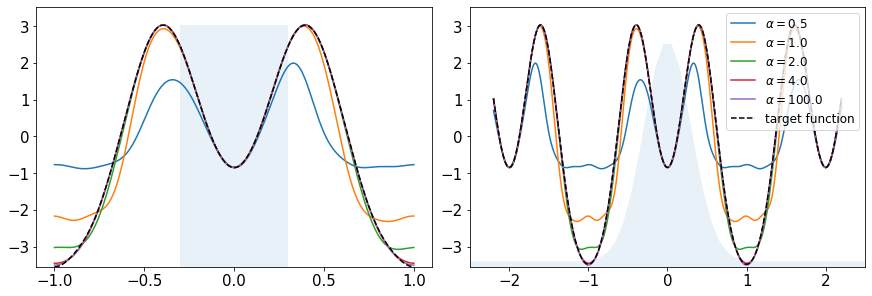

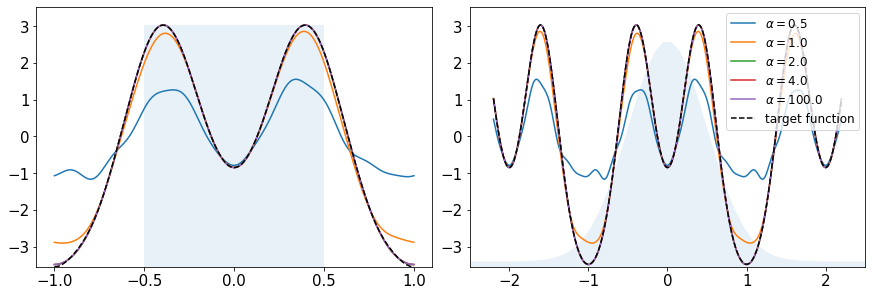

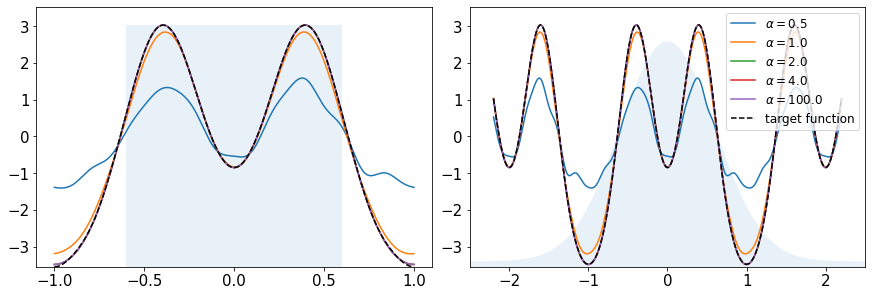

In [ ]:
mean_fine, std_fine, mean_test, std_test = [mean_fine_gauss, std_fine_gauss, mean_test_gauss, std_test_gauss]
for t, tr_range in enumerate(tr_range_list):
  fontsize = '30'
  fig, axs = plt.subplots(1,2,figsize=(12,4),constrained_layout=True)
  plt.rcParams.update({'font.size': 15})
  for i, y in enumerate(mean_fine[t]):
    if i < 10:
        axs[0].plot(x_fine, y, label = r'$\alpha =%0.1f $'% (0.5 * pvals[i] / num_k), color = 'C%d'% i)
        axs[1].plot(x_test, mean_test[t][i], label = r'$\alpha =%0.1f $'% (0.5 * pvals[i] / num_k), color = 'C%d'% i)
        axs[0].set_ylim([min(target), max(target)+0.5])
        axs[1].set_ylim([min(target)-0.3, max(target)+0.5])
        axs[1].set_xlim([-2.5, 2.5])

  axs[0].fill_between([-tr_range, tr_range], min(target),max(target), alpha = 0.1)
  r = np.linspace(-5, 5,100)
  axs[1].fill_between(r,6*np.exp(-r**2/(2*tr_range**2))-3.4, y2 = -4, alpha = 0.1)
  axs[0].plot(x_fine, target, '--', color = 'black', label='target function')
  axs[1].plot(x_test, f_centered(x_test), '--', color = 'black', label='target function')

  plt.legend(fontsize=12, loc='upper right')
  plt.ylim([min(target), max(target)+0.5])
  plt.show()

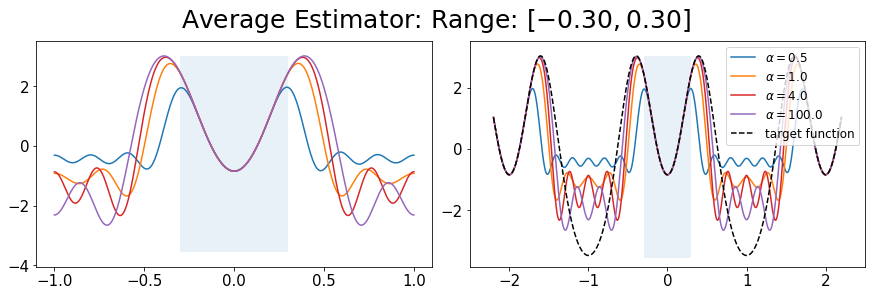

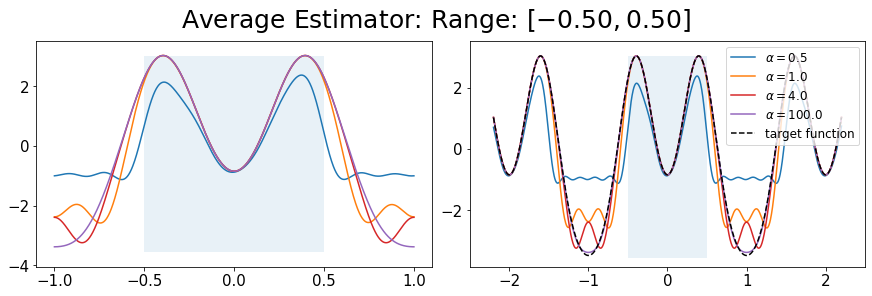

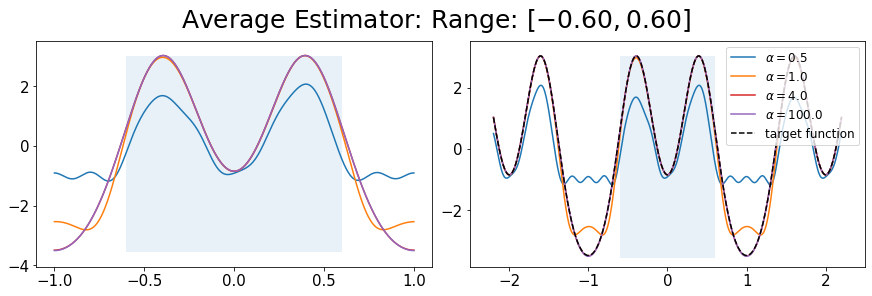

In [ ]:
mean_fine, std_fine, mean_test, std_test = [mean_fine_rect, std_fine_rect, mean_test_rect, std_test_rect]
for t, tr_range in enumerate(tr_range_list):
  fontsize = '30'
  fig, axs = plt.subplots(1,2,figsize=(12,4),constrained_layout=True)
  plt.rcParams.update({'font.size': 15})
  for i, y in enumerate(mean_fine[t]):
    if i not in [2]:
        axs[0].plot(x_fine, y, label = r'$\alpha =%0.1f $'% (0.5 * pvals[i] / num_k), color = 'C%d'% i)
        axs[1].plot(x_test, mean_test[t][i], label = r'$\alpha =%0.1f $'% (0.5 * pvals[i] / num_k), color = 'C%d'% i)
        axs[0].set_ylim([min(target)-0.5, max(target)+0.5])
        axs[1].set_ylim([min(target)-0.3, max(target)+0.5])
        axs[1].set_xlim([-2.5, 2.5])

  axs[0].fill_between([-tr_range, tr_range], min(target),max(target), alpha = 0.1)
  axs[1].fill_between([-tr_range, tr_range], min(target),max(target), alpha = 0.1)
  axs[1].plot(x_test, f_centered(x_test), '--', color = 'black', label='target function')

  plt.legend(fontsize=12, loc='upper right')
  
  fig.suptitle('Average Estimator: Range: $[-%0.2f,%0.2f]$'%(tr_range,tr_range), fontsize = '25')
  plt.show()

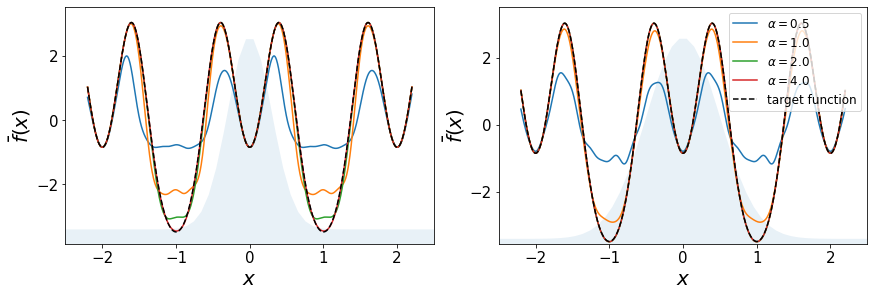

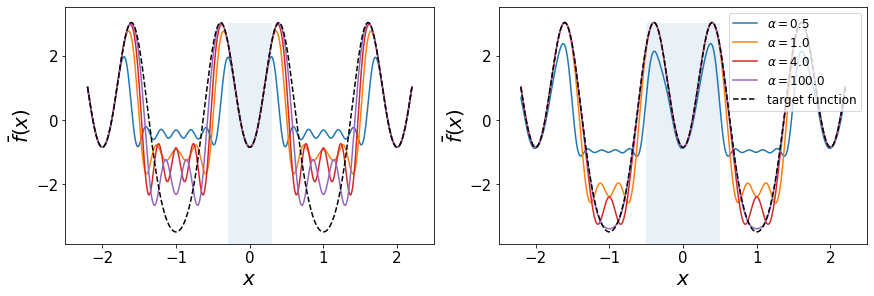

In [ ]:
mean_fine, std_fine, mean_test, std_test = [mean_fine_gauss, std_fine_gauss, mean_test_gauss, std_test_gauss]
fontsize = '30'
fig, axs = plt.subplots(1,2,figsize=(12,4),constrained_layout=True)
plt.rcParams.update({'font.size': 15})
for t, tr_range in enumerate(np.array(tr_range_list)[:2]):
  for i, y in enumerate(mean_fine[t]):
    if i < 4:
        axs[t].plot(x_test, mean_test[t][i], label = r'$\alpha =%0.1f $'% (0.5 * pvals[i] / num_k), color = 'C%d'% i)
        axs[t].set_ylim([min(target)-0.3, max(target)+0.5])
        axs[t].set_xlim([-2.5, 2.5])
        axs[t].set_xlabel('$x$', fontsize=20)
        axs[t].set_ylabel('$\\bar{f}(x)$', fontsize=20)

  r = np.linspace(-5, 5,100)
  axs[t].fill_between(r,6*np.exp(-r**2/(2*tr_range**2))-3.4, y2 = -4, alpha = 0.1)
  axs[t].plot(x_test, f_centered(x_test), '--', color = 'black', label='target function')

plt.legend(fontsize=12, loc='upper right')
plt.ylim([min(target), max(target)+0.5])
if save_data: plt.savefig(save_dir+'average_estimator_gaussian.pdf')

plt.show()


mean_fine, std_fine, mean_test, std_test = [mean_fine_rect, std_fine_rect, mean_test_rect, std_test_rect]
fontsize = '30'
fig, axs = plt.subplots(1,2,figsize=(12,4),constrained_layout=True)
plt.rcParams.update({'font.size': 15})
for t, tr_range in enumerate(np.array(tr_range_list)[:2]):
  for i, y in enumerate(mean_fine[t]):
    if i not in [2]:
        axs[t].plot(x_test, mean_test[t][i], label = r'$\alpha =%0.1f $'% (0.5 * pvals[i] / num_k), color = 'C%d'% i)
        axs[t].set_ylim([min(target)-0.3, max(target)+0.5])
        axs[t].set_xlim([-2.5, 2.5])
        axs[t].set_xlabel('$x$', fontsize=20)
        axs[t].set_ylabel('$\\bar{f}(x)$', fontsize=20)

  axs[t].fill_between([-tr_range, tr_range], min(target)-0.3, max(target), alpha = 0.1)
  axs[t].plot(x_test, f_centered(x_test), '--', color = 'black', label='target function')

plt.legend(fontsize=12, loc='upper right')
  
if save_data: plt.savefig(save_dir+'average_estimator_rectangular.pdf')
plt.show()

In [ ]:
key = random.PRNGKey(1)
p = 8000
x_rect = [jnp.sort(random.uniform(key, minval = -1, maxval = 1, shape = (p,)))*tr_range for tr_range in tr_range_list]
x_gauss = [jnp.sort(random.normal(key, shape = (p,)))*tr_range for tr_range in tr_range_list]

x_rect = jnp.array(x_rect)
x_gauss = jnp.array(x_gauss)

f_rect = [f_centered(x) for x in x_rect]
f_gauss = [f_centered(x) for x in x_gauss]

K_rect = [kernel(x,x) for x in x_rect]
K_gauss = [kernel(x,x) for x in x_gauss]

eig_rect = []
vec_rect = []
for K in K_rect:
  sol = jnp.linalg.eigh(K)
  eig_rect += [sol[0][::-1]]
  vec_rect += [sol[1][:,::-1]]

eig_gauss = []
vec_gauss = []
for K in K_gauss:
  sol = jnp.linalg.eigh(K)
  eig_gauss += [sol[0][::-1]]
  vec_gauss += [sol[1][:,::-1]]

targ_power_rect = []
for i, vec in enumerate(vec_rect):
  targ_power_rect += [f_rect[i]@vec]

targ_power_gauss = []
for i, vec in enumerate(vec_gauss):
  targ_power_gauss += [f_gauss[i]@vec]

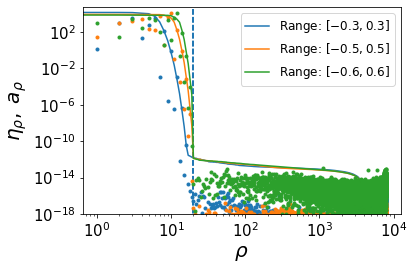

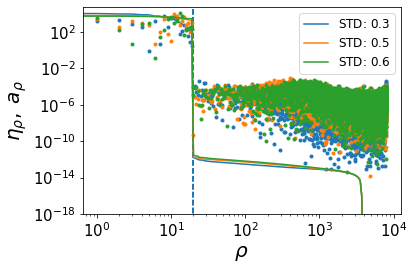

In [ ]:
for i, eig in enumerate(eig_rect):
  plt.loglog(eig, color='C%d'%i, label = 'Range: $[-%0.1f,%0.1f]$'%(tr_range_list[i],tr_range_list[i]))
  plt.plot(targ_power_rect[i]**2, '.', color='C%d'%i)
  plt.vlines(20,0,1e+7, linestyles='dashed')

plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\eta_\rho,\; a_\rho$', fontsize=20)

plt.legend(fontsize=12)
plt.ylim([1e-18,5e+4])
plt.tight_layout()
if save_data: plt.savefig(save_dir+'eig_target_power_rect.pdf')
plt.show()

for i, eig in enumerate(eig_gauss):
  plt.loglog(eig, color='C%d'%i,label = 'STD: $%0.1f$'%(tr_range_list[i]))
  plt.plot(targ_power_gauss[i]**2, '.', color='C%d'%i)
  plt.vlines(20,0,1e+7, linestyles='dashed')

plt.xlabel(r'$\rho$', fontsize=20)
plt.ylabel(r'$\eta_\rho,\; a_\rho$', fontsize=20)

plt.legend(fontsize=12)
plt.ylim([1e-18,5e+4])
plt.tight_layout()
if save_data: plt.savefig(save_dir+'eig_target_power_gauss.pdf')
plt.show()